# 💪 Deep Facial Emotion Detection Model
Custom-built thick CNN inspired by high-performing text model architecture.

In [1]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [4]:

# === CONFIGURATION ===
image_size = (96, 96)
batch_size = 32
epochs = 2
train_dir = "dataset/train"
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)


In [5]:

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True
)

class_labels = list(train_data.class_indices.keys())
num_classes = len(class_labels)


Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.


In [6]:

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = LeakyReLU()(x)
    return x

def build_deep_emotion_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_deep_emotion_model((96, 96, 1), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 96, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 96, 96, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 64)           0         ['batch_normalization[0][0

In [7]:

# === TRAIN MODEL ===
early_stop = EarlyStopping(patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(os.path.join(model_dir, 'best_weights.h5'), save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/2
763/763 [==============================] - ETA: 0s - loss: 1.8021 - accuracy: 0.2535

/home/aarons/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


763/763 [==============================] - 669s 864ms/step - loss: 1.8021 - accuracy: 0.2535 - val_loss: 1.7498 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 2/2
763/763 [==============================] - 654s 858ms/step - loss: 1.7096 - accuracy: 0.3085 - val_loss: 1.8185 - val_accuracy: 0.2652 - lr: 0.0010


In [8]:

# === SAVE MODEL ===
model_json = model.to_json()
with open(os.path.join(model_dir, "emotion_model.json"), "w") as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(model_dir, "emotion_model_weights.h5"))
model.save("saved_model")
print("✅ Model saved (JSON, weights, SavedModel)")


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


✅ Model saved (JSON, weights, SavedModel)


In [9]:

# === EVALUATE MODEL ===
val_data.reset()
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_data.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


135/135 [==============================] - 32s 235ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.17      0.00      0.00       599
   disgusted       0.00      0.00      0.00        65
     fearful       0.05      0.00      0.00       614
       happy       0.25      0.37      0.30      1082
     neutral       0.19      0.03      0.06       744
         sad       0.18      0.61      0.27       724
   surprised       0.05      0.00      0.00       475

    accuracy                           0.20      4303
   macro avg       0.13      0.15      0.09      4303
weighted avg       0.16      0.20      0.13      4303



/home/aarons/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aarons/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aarons/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 67ms/step
2022-05-25_23-41_png_jpg.rf.bd53e78be6a161eca22d4be1c5db7331.jpg → sad (29.68%)


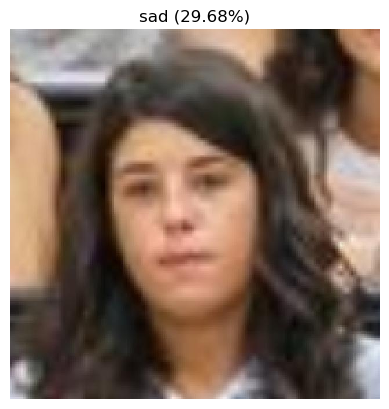

In [16]:

# === INFER IMAGES LOCALLY ===
def predict_emotions_from_images(folder):
    for img_file in os.listdir(folder):
        if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        path = os.path.join(folder, img_file)
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, image_size)

        face_img = resized.astype("float32") / 255.0
        face_img = np.expand_dims(face_img.reshape(image_size[0], image_size[1], 1), axis=0)

        preds = model.predict(face_img)[0]
        label = class_labels[np.argmax(preds)]
        confidence = np.max(preds)

        print(f"{img_file} → {label} ({confidence*100:.2f}%)")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{label} ({confidence*100:.2f}%)")
        plt.axis('off')
        plt.show()

# Uncomment to test:
predict_emotions_from_images("images")
